# Features optimisation (cont.)

This notebook will explore optimisation approaches that would work with continuous input data.

In [1]:
from pathlib import Path

import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyHSICLasso.hsic_lasso import compute_kernel
from numba import njit

from hsic_optimization.hsic_tools import generate

## Dataset generation

For testing purpose, we will use only 1 feature with 1,000,000 samples.

In [2]:
n_samples = 1_000_000
n_features = 1
n_active = 1
dset_file = Path(f"../data/test_dataset_{n_features}_by_{n_samples}_continous.h5")

In [3]:
if not dset_file.exists():
    generate(
        dset_file,
        samples=n_samples,
        feats=n_features,
        active=n_active,
        seed=1234,
        continuous_features=True,
        continuous_target=True,
    )

In [4]:
with h5py.File(dset_file, "r") as fd:
    X = np.array(fd["X"])

For comparison purpose, let's compute the Gaussian kernel feature with pyHSICLasso.

In [5]:
%%time
B = 20
M = 3

k_ref = compute_kernel(X, "Gaussian", B=B, M=M)
k_ref.shape

CPU times: user 13 s, sys: 54.2 ms, total: 13.1 s
Wall time: 13.1 s


(60000000,)

In [6]:
%%timeit
compute_kernel(X, "Gaussian", B=B, M=M)

12.8 s ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Accelerated Gaussian feature function

First, let's check the performance of the best method suitable for continuous input, i.e. without a look up table approach, from the [Feature matrices optimization](03a_feature_optimization.ipynb) notebook.

In [7]:
@njit(nogil=True, cache=True)
def kernel_gaussian_1(x):
    n = len(x)
    out = np.empty((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(i, n):
            res = np.exp(-((x[i] - x[j]) ** 2) * 0.5)
            out[i, j] = res
            out[j, i] = res
    return out


def compute_kernel_1(x, B=0, M=1, discarded=0):
    n = len(x)
    H = np.eye(B, dtype=np.float32) - np.full((B, B), 1 / B, dtype=np.float32)
    K = np.zeros(n * B * M, dtype=np.float32)

    st = 0
    ed = B**2
    index = np.arange(n)
    for m in range(M):
        np.random.seed(m)
        index = np.random.permutation(index)
        X_k = x[index]

        for i in range(0, n - discarded, B):
            j = min(n, i + B)

            k = kernel_gaussian_1(X_k[i:j])
            k = (H @ k) @ H
            k = k / (np.sqrt(np.sum(k**2)) + 1e-9)

            K[st:ed] = k.ravel()
            st += B**2
            ed += B**2

    return K

In [8]:
%%timeit
compute_kernel_1(X[0], B, M)

4.76 s ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
k_1 = compute_kernel_1(X[0] / X[0].std(), B, M)
np.allclose(k_ref, k_1)

False

Results do not match, likely due to the same numerical precision issue highlighted in the
[Feature matrices optimization](03a_feature_optimization.ipynb) notebook.

Examining the differences, they are confined to values close to 0.

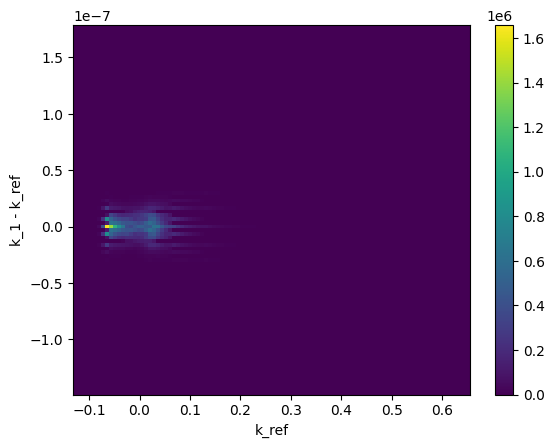

In [10]:
plt.hist2d(k_ref, k_1 - k_ref, bins=100)
plt.colorbar()
plt.xlabel("k_ref")
plt.ylabel("k_1 - k_ref")
ax = plt.gca()

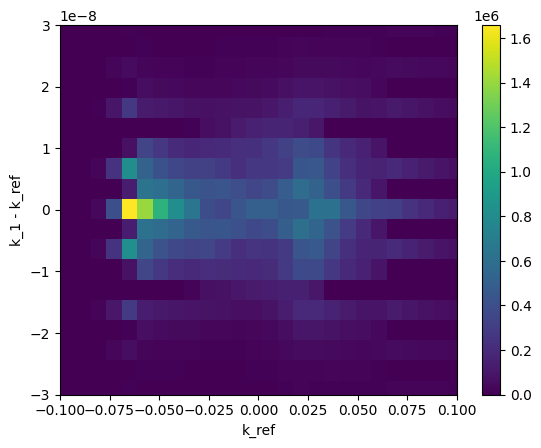

In [11]:
ax.set_xlim(left=-0.1, right=0.1)
ax.set_ylim(bottom=-3e-8, top=3e-8)
ax.figure

We can jit-compile the `compute_kernel_1` function to make the code even faster.

In [12]:
compute_kernel_1b = njit(nogil=True, cache=True)(compute_kernel_1)
k_1b = compute_kernel_1b(X[0], B, M)
np.allclose(k_1, k_1b)

False

In [13]:
%%timeit
compute_kernel_1b(X[0], B, M)

1.36 s ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can also try to use the `fastmath` option, if this doesn't change the results too much from the first accelerated version.

In [14]:
compute_kernel_1c = njit(fastmath=True, nogil=True, cache=True)(compute_kernel_1)
k_1c = compute_kernel_1c(X[0], B, M)
np.allclose(k_1, k_1c)

False

In [15]:
%%timeit
compute_kernel_1c(X[0], B, M)

1.36 s ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Linear algebra libraries

Let's double check which version of BLAS is used.

In [16]:
np.show_config()

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /usr/local/include
    lib directory: /usr/local/lib
    name: openblas64
    openblas configuration: USE_64BITINT=1 DYNAMIC_ARCH=1 DYNAMIC_OLDER= NO_CBLAS=
      NO_LAPACK= NO_LAPACKE= NO_AFFINITY=1 USE_OPENMP= HASWELL MAX_THREADS=2
    pc file directory: /usr/local/lib/pkgconfig
    version: 0.3.23.dev
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep139863411681952
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.4
Compilers:
  c:
    args: -fno-strict-aliasing
    commands: cc
    linker: ld.bfd
    linker args: -Wl,--strip-debug, -fno-strict-aliasing
    name: gcc
    version: 10.2.1
  c++:
    commands: c++
    linker: ld.bfd
    linker args: -Wl,--strip-debug
    name: gcc
    version: 10.2.1
  cython:
    commands: cython
    linker: cython
    name: cython
    versio